In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.special import logsumexp
import pymc3 as pm
import theano.tensor as TT
import accuracy_analysis as aa


In [24]:
import matplotlib as mpl
mpl.style.use('default')
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

c0 = cycle[0]
c1 = cycle[1]
c2 = cycle[2]
c3 = cycle[3]


mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.top'] = True
mpl.rcParams['axes.spines.right'] = True

mpl.rcParams["xtick.minor.visible"] =  True
mpl.rcParams["ytick.minor.visible"] =  True
mpl.rcParams["xtick.bottom"] =  True
mpl.rcParams["ytick.left"] =  True

mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.direction'] = 'in'# could be 'in' 'out', or 'inout'
mpl.rcParams['ytick.direction'] = 'in'

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{txfonts}',\
                                       r'\usepackage[T1]{fontenc}']


In [2]:
def make_sample(N, f_M, r_Ms, r_Is, seed=None):
    np.random.seed(seed)
    true_gals = np.random.choice([0,1], size=N, p=[1-f_M, f_M])
    f_M_sample = true_gals.sum()/N
    N_true = true_gals.sum()
    
    n = len(r_Ms)
    

    # Matrix of classifier answers
    m = np.zeros((n, N), dtype='int')
    for i in range(n):
        for j in range(N):
            if true_gals[j] == 0:
                m[i,j] = np.random.choice([0,1], p=[r_Is[i], 1-r_Is[i]])
            elif true_gals[j] == 1:
                m[i,j] = np.random.choice([0,1], p=[1-r_Ms[i], r_Ms[i]])

    
    return N_true, m, true_gals

In [3]:
def make_flat(observations):
    n_cfers, n_obj = observations.shape
    obs_flat = observations.ravel()
    
    cfer_ids = np.zeros([n_cfers, n_obj], dtype='int')
    for i in range(n_cfers):
        cfer_ids[i] = i
    cfer_ids = cfer_ids.ravel()
    
    obj_ids = np.zeros([n_cfers, n_obj], dtype='int')
    for j in range(n_obj):
        obj_ids[:, j] = j
    obj_ids = obj_ids.ravel()
    
    return obs_flat, obj_ids, cfer_ids

In [4]:
def get_beta_pars(truths, observed):
    t0 = (truths==0)
    t1 = (truths==1)
    o0 = (observed==0)
    o1 = (observed==1)
    
    a_00 = np.count_nonzero(t0 & o0, axis=1) + 1
    b_00 = np.count_nonzero(t0 & o1, axis=1) + 1
    b_11 = np.count_nonzero(t1 & o0, axis=1) + 1
    a_11 = np.count_nonzero(t1 & o1, axis=1) + 1
    
    return a_00, b_00, a_11, b_11


In [5]:
def get_chains(obs, obs_train, true_train):
    '''
    these arrays are n_galaxies x n_classifiers, and are 0 for isolated, 1 for merger.
    '''
    obs_classes, obj_ids, cfer_ids = make_flat(obs)
    a_00, b_00, a_11, b_11 = get_beta_pars(true_train, obs_train) 
    
    n_cfers, n_obj = obs.shape
    
    with pm.Model() as explicit_model:
        f_M  = pm.Beta('fM', alpha=0.5, beta=0.5)
        r_Is = pm.Beta('rI', alpha=a_00, beta=b_00, shape=n_cfers)
        r_Ms = pm.Beta('rM', alpha=a_11, beta=b_11, shape=n_cfers)
    
        #the "real" data
        true_class = pm.Bernoulli('true_class', f_M, shape=n_obj)
        N_M_true = pm.Deterministic('N_M', TT.sum(true_class))
        p_obs_1 = TT.switch(TT.eq(true_class[obj_ids], 1), r_Ms[cfer_ids], 1-r_Is[cfer_ids])
        observed = pm.Bernoulli('observed', p_obs_1, observed=obs_classes)

    with explicit_model:
        trace = pm.sample(draws=5000)

    return trace.get_values('fM'), trace.get_values('rI'), trace.get_values('rM'), trace.get_values('true_class')

In [57]:
from scipy.special import beta as Beta

def make_obs(n_cfers=2, seed=0, f_M_true=0.2, f_M_train=0.5, n_obj=40, n_train=40):
    np.random.seed(seed)
    cfer_probs = np.random.uniform(low=0.5, high=0.9, size=n_cfers*2).reshape(-1,2)

    r_Is = cfer_probs[:, 0]
    r_Ms = cfer_probs[:, 1]

    true, obs, true_samp = make_sample(n_obj, f_M_true, r_Ms, r_Is, seed=1234)

    true_train, obs_train, true_samp_train = make_sample(n_train, f_M_train, r_Ms, r_Is, seed=123)
    return obs, true, obs_train, true_train, true_samp

def analyze_sample(obs, obs_train, true_train, true_samp):

    f_Ms, r_Is, r_Ms, classif = get_chains(obs, obs_train, true_train)

    return f_Ms, r_Is, r_Ms, classif

In [10]:
obs, true, obs_train, true_train, true_samp = make_obs(n_cfers=14)

In [70]:
#for mock data with real classifiers
import pandas as pd 
df_full = pd.read_hdf('/home/erini/Mergers/df_full_04272020.hdf5','table')
df_mock = pd.read_csv('/home/erini/Mergers/mock_question_key.csv')

inds = np.arange(41)
f_mhats = np.zeros((14,41))
f_mhatss = np.array((14,41))


merger = ['MaM', 'MaD', 'MiM']

not_fake_indexes = df_mock.mock_question_num[df_mock.type != 'f'].sort_values().values

survey_index = df_full.set_type[not_fake_indexes].index

from tqdm import tqdm
for i in tqdm(range(41)):
    k = survey_index[i]
    s = df_full.loc[k][2::2]
    for j in range(14):
        if s[j] in merger:
             f_mhats[j,i] = 1

inds = np.arange(41)
true_samp = np.zeros(41)

merger = ['m']

from tqdm import tqdm
for i in tqdm(range(41)):
    k = survey_index[i]
    s = df_mock.type[df_mock.mock_question_num == k]
    if s.values in merger:
             true_samp[i] = 1                
                
obs = f_mhats
obs_train = f_mhats
true_train = 41

np.shape(obs)


100%|██████████| 41/41 [00:00<00:00, 1193.95it/s]


(14, 41)

In [64]:
#b_obs, true, obs_train, true_train, true_samp = make_obs(n_cfers=14)

In [97]:
f_Ms, r_Is, r_Ms, classif = analyze_sample(obs, obs_train, true_train, obs_train)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [rM, rI, fM]
>BinaryGibbsMetropolis: [true_class]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


[0.41697302 0.4938959  0.57097522]


(0, 1)

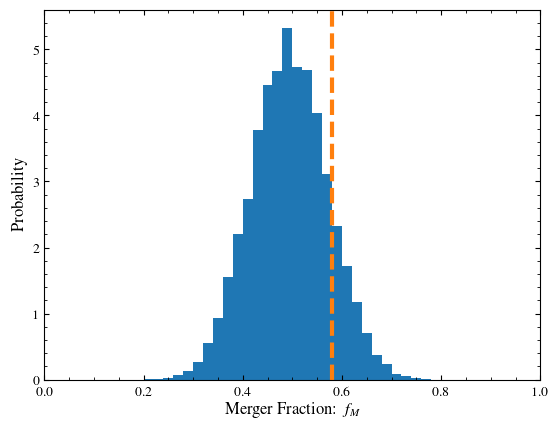

In [98]:
plt.figure()

plt.hist(f_Ms,bins=np.linspace(0,1,51), density=True)
plt.xlabel(r'Merger Fraction: $f_M$',fontsize=12)
plt.ylabel(r'Probability',fontsize=12)
plt.axvline(0.58,c='C1',linestyle='dashed',linewidth=3)
print(np.percentile(f_Ms, [16, 50, 84]))
n_cfers, n_obj = obs.shape

plt.xlim(0,1)


(array([9568., 4519.,  817.,   83.,   15.,   34.,  239., 1173., 2417.,
        1135.]),
 array([1.88159009e-04, 9.89696397e-02, 1.97751120e-01, 2.96532601e-01,
        3.95314082e-01, 4.94095562e-01, 5.92877043e-01, 6.91658524e-01,
        7.90440004e-01, 8.89221485e-01, 9.88002966e-01]),
 <a list of 10 Patch objects>)

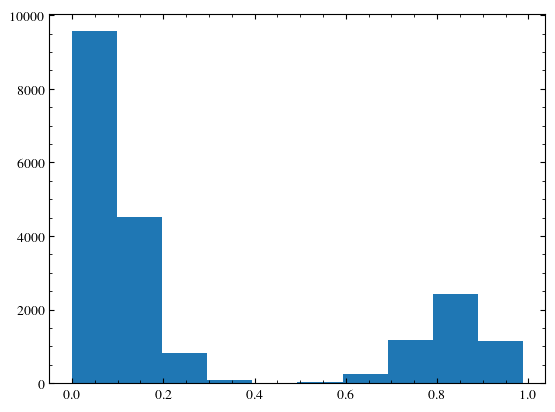

In [104]:
plt.hist(r_Ms[:,2])

In [90]:
# Binomial distribution assuming that all of the galaxies were classified perfectly
# Fundamental limit to which a sample's merger fraction can be determined.
#alpha=int(np.median(f_Ms)*n_obj)+1
#beta = n_obj-true+1
#p = np.linspace(0, 0.5, 1000)
#plt.plot(p,p**(alpha-1)*(1-p)**(beta-1)/Beta(alpha,beta))

p_Ms = np.zeros((1000, n_obj))
p_Ms = []
for k in np.random.choice(np.arange(len(f_Ms)), size=1000):
    for j in range(n_obj):
        num = 1
        den_I = 1
        den_M = 1
        for i in range(n_cfers):
            if obs[i,j] == 0:
                num *= (1-r_Ms[k,i])
                den_M *= (1-r_Ms[k,i])
                den_I *= r_Is[k,i]
            else:
                num *= r_Ms[k,i]
                den_M *= r_Ms[k,i]
                den_I *= (1-r_Ms[k,i])
        p_Ms.append(num*f_Ms[k]/(den_M*f_Ms[k]+den_I*(1-f_Ms[k])))
p_Ms = np.array(p_Ms)
p_Ms = p_Ms.reshape(-1, 41)


#print p_Ms
#print true_samp
yll, mu, yul = np.percentile(p_Ms, [16,50,68], axis=0)
print mu
print yll
print yul

[7.67569883e-09 4.43717139e-04 4.92889874e-09 1.00000000e+00
 3.34924073e-07 1.00000000e+00 1.61278106e-08 9.99997377e-01
 1.21142023e-04 4.92889874e-09 1.00000000e+00 4.92889874e-09
 1.00000000e+00 9.99997221e-01 9.99999998e-01 4.92889874e-09
 1.00000000e+00 1.00000000e+00 4.92889874e-09 1.00000000e+00
 3.74054778e-02 1.00000000e+00 4.92889874e-09 1.00000000e+00
 2.43808468e-04 8.56584082e-07 4.92889874e-09 9.99995507e-01
 9.99872908e-01 1.00000000e+00 2.14298878e-05 9.99999999e-01
 4.92889874e-09 9.45257193e-07 4.92889874e-09 4.92889874e-09
 1.00000000e+00 1.00000000e+00 9.99999993e-01 9.99999468e-01
 4.92889874e-09]
[7.20846762e-10 4.06737885e-05 5.00775775e-10 1.00000000e+00
 3.56709540e-08 1.00000000e+00 1.64875069e-09 9.99960352e-01
 1.19896014e-05 5.00775775e-10 1.00000000e+00 5.00775775e-10
 1.00000000e+00 9.99969930e-01 9.99999963e-01 5.00775775e-10
 1.00000000e+00 1.00000000e+00 5.00775775e-10 1.00000000e+00
 4.18140471e-03 1.00000000e+00 5.00775775e-10 9.99999999e-01
 2.2227

[1.02012432e-08 5.10936453e-04 5.59710454e-09 1.00000000e+00
 4.34975762e-07 1.00000000e+00 1.77697186e-08 9.99997733e-01
 1.22967047e-04 5.59710454e-09 1.00000000e+00 5.59710454e-09
 1.00000000e+00 9.99997494e-01 9.99999998e-01 5.59710454e-09
 1.00000000e+00 1.00000000e+00 5.59710454e-09 1.00000000e+00
 4.15518826e-02 1.00000000e+00 5.59710454e-09 1.00000000e+00
 3.12761048e-04 9.10711303e-07 5.59710454e-09 9.99995558e-01
 9.99871759e-01 1.00000000e+00 2.10065866e-05 1.00000000e+00
 5.59710454e-09 9.27448968e-07 5.59710454e-09 5.59710454e-09
 1.00000000e+00 1.00000000e+00 9.99999993e-01 9.99999421e-01
 5.59710454e-09]


Text(0,0.5,'$p_M$')

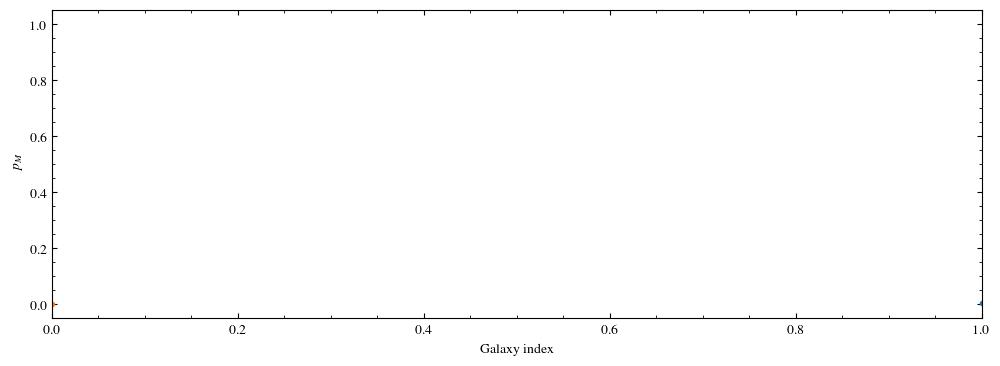

In [87]:
plt.figure(figsize=(12,4))
yll, mu, yul = np.percentile(p_Ms, [16,50,68], axis=0)

inds = (true_samp == 0)
plt.errorbar(np.arange(41)[inds], mu[inds], yerr=[mu[inds]-yll[inds], yul[inds]-mu[inds]], fmt='.')
inds = (true_samp == 1)
plt.errorbar(np.arange(41)[inds], mu[inds], yerr=[mu[inds]-yll[inds], yul[inds]-mu[inds]], fmt='.')
plt.xlim(0,1)
plt.xlabel('Galaxy index')
plt.ylabel(r'$p_M$')


In [ ]:
p_Ms = np.zeros((1000, n_obj))
p_Ms = []
for k in np.random.choice(np.arange(len(f_Ms)), size=1000):
    for j in range(n_obj):
        num = 1
        den_I = 1
        den_M = 1
        for i in range(n_cfers):
            if obs[i,j] == 0:
                num *= (1-r_Ms[k,i])
                den_M *= (1-r_Ms[k,i])
                den_I *= r_Is[k,i]
            else:
                num *= r_Ms[k,i]
                den_M *= r_Ms[k,i]
                den_I *= (1-r_Ms[k,i])
        p_Ms.append(num/(den_M+den_I))
p_Ms = np.array(p_Ms)
p_Ms = p_Ms.reshape(-1, 200)

plt.figure(figsize=(12,4))
yll, mu, yul = np.percentile(p_Ms, [16,50,68], axis=0)
inds = (true_samp == 0)
plt.errorbar(np.arange(200)[inds], mu[inds], yerr=[mu[inds]-yll[inds], yul[inds]-mu[inds]], fmt='.')
inds = (true_samp == 1)
plt.errorbar(np.arange(200)[inds], mu[inds], yerr=[mu[inds]-yll[inds], yul[inds]-mu[inds]], fmt='.')
plt.xlabel('Galaxy index')
plt.ylabel(r'$p_M$')
plt.title('Flat prior')


In [7]:
obs, true, obs_train, true_train, true_samp = make_obs(n_cfers=32)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [rM, rI, fM]
>BinaryGibbsMetropolis: [true_class]


[0.17164822 0.19924942 0.22836079]


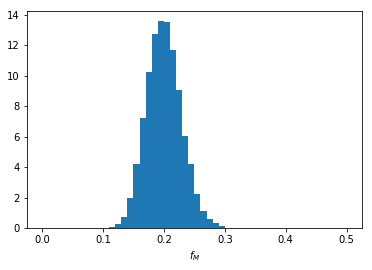

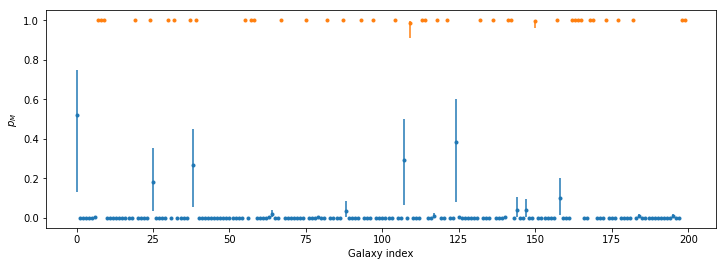

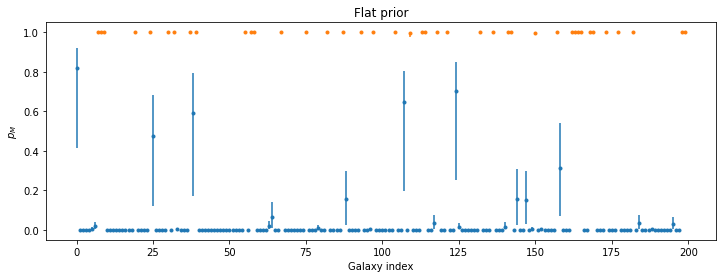

In [8]:
analyze_sample(obs, obs_train, true_train, true_samp)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [rM, rI, fM]
>BinaryGibbsMetropolis: [true_class]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [02:31<00:00, 145.45draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.14724878 0.18552738 0.22961972]


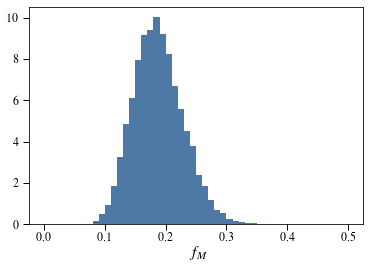

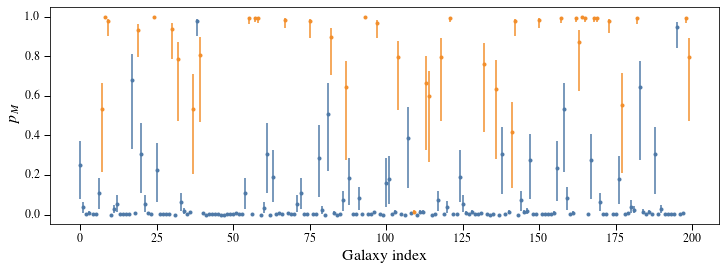

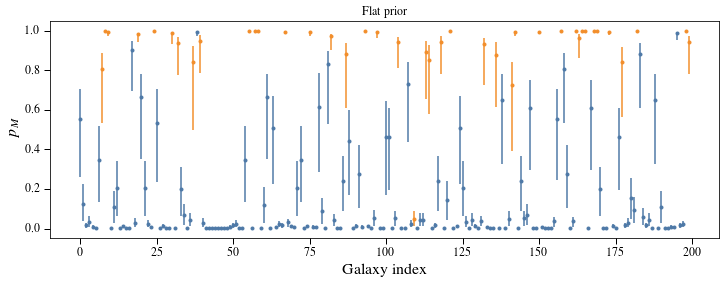

In [9]:
analyze_sample(obs[:8], obs_train[:8], true_train, true_samp)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [rM, rI, fM]
>BinaryGibbsMetropolis: [true_class]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [03:40<00:00, 99.72draws/s] 


[0.17946443 0.20813962 0.23900215]


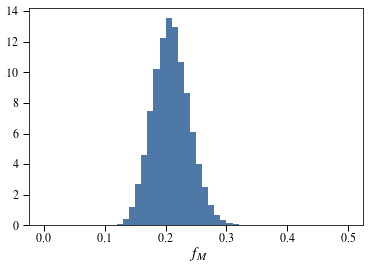

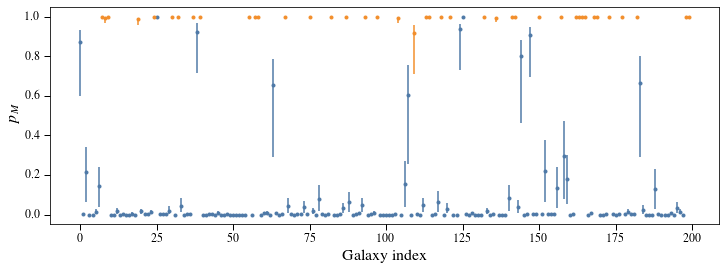

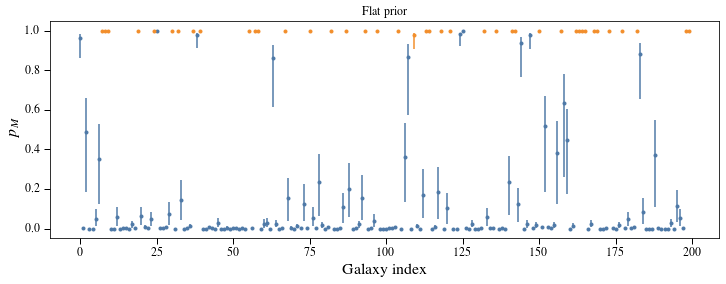

In [10]:
analyze_sample(obs[:16], obs_train[:16], true_train, true_samp)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [rM, rI, fM]
>BinaryGibbsMetropolis: [true_class]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [05:53<00:00, 62.21draws/s]


[0.17168609 0.19913089 0.2280251 ]


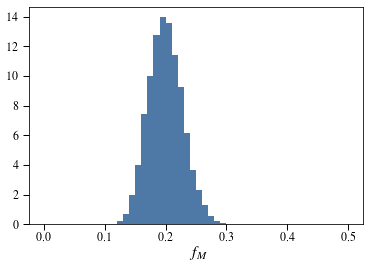

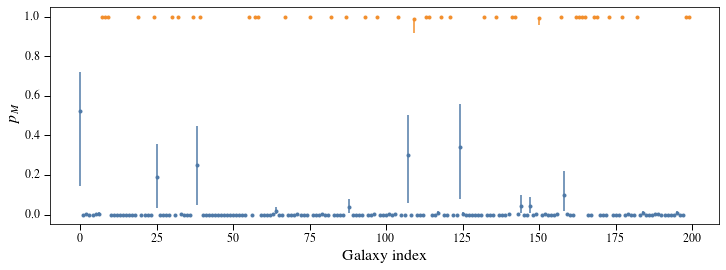

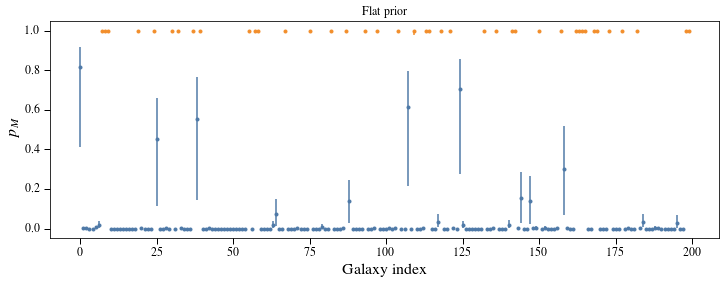

In [11]:
analyze_sample(obs[:32], obs_train[:32], true_train, true_samp)